# Port wavelet method spike detection

In [173]:
%load_ext autoreload
import numpy as np 
import os 

import sys
sys.path.append("/home/timsit/mecp2/python/")
import mea_util
import spike_detection as dspikes
import process_spikes as pspikes
import vizpikes 

# Wavelet

import pywt


# plotting 
import sciplotlib.style as splstyle

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load some data to test that it is running properly

In [5]:
pre_ttx_path = '/home/timsit/mecp2/data/MPT200209_3A_DIV12.mat'
pre_ttx_data = mea_util.hdf_loadmat(pre_ttx_path)

/home/timsit/mecp2/python/mea_util.py:7: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  f = h5py.File(mat_filepath)


## Go through the code (almost line by line) to check the output is the same

In [224]:
# specify the parameters
signal = pre_ttx_data['dat']
SFr = 25 # in Khz
Wid = [0.5, 1.0]
Ns = 2
option = 'c'
L = 0
wname = 'bior1.5'

In [225]:
# Mean subtraction on the signal so that it has zero-mean
signal = signal - np.mean(signal)

In [226]:
Nt = len(signal)  # number of time poinnts

### Determine scales

In [227]:
_signal = np.zeros(shape=(1000))

In [228]:
dt = 1 / SFr

In [229]:
_signal[499] = 1

In [230]:
Width = np.linspace(Wid[0], Wid[1], Ns)

In [231]:
Eps = 10 ** (-15)

In [232]:
ScaleMax = 3
ScaleMax = ScaleMax * SFr

In [233]:
Scales = np.arange(2, ScaleMax+1)

In [276]:
c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet='gaus5')
# c, _ = pywt.cwt(data=_signal, scales=Scales, wavelet='mexh')

### Can gaus5 replace bior1.5

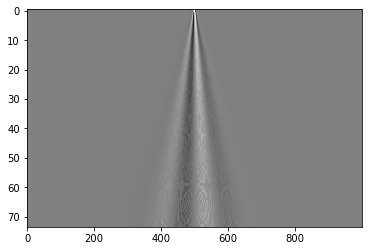

In [277]:
plt.imshow(c, aspect='auto', cmap='gray')

In [236]:
np.shape(c)

(74, 1000)

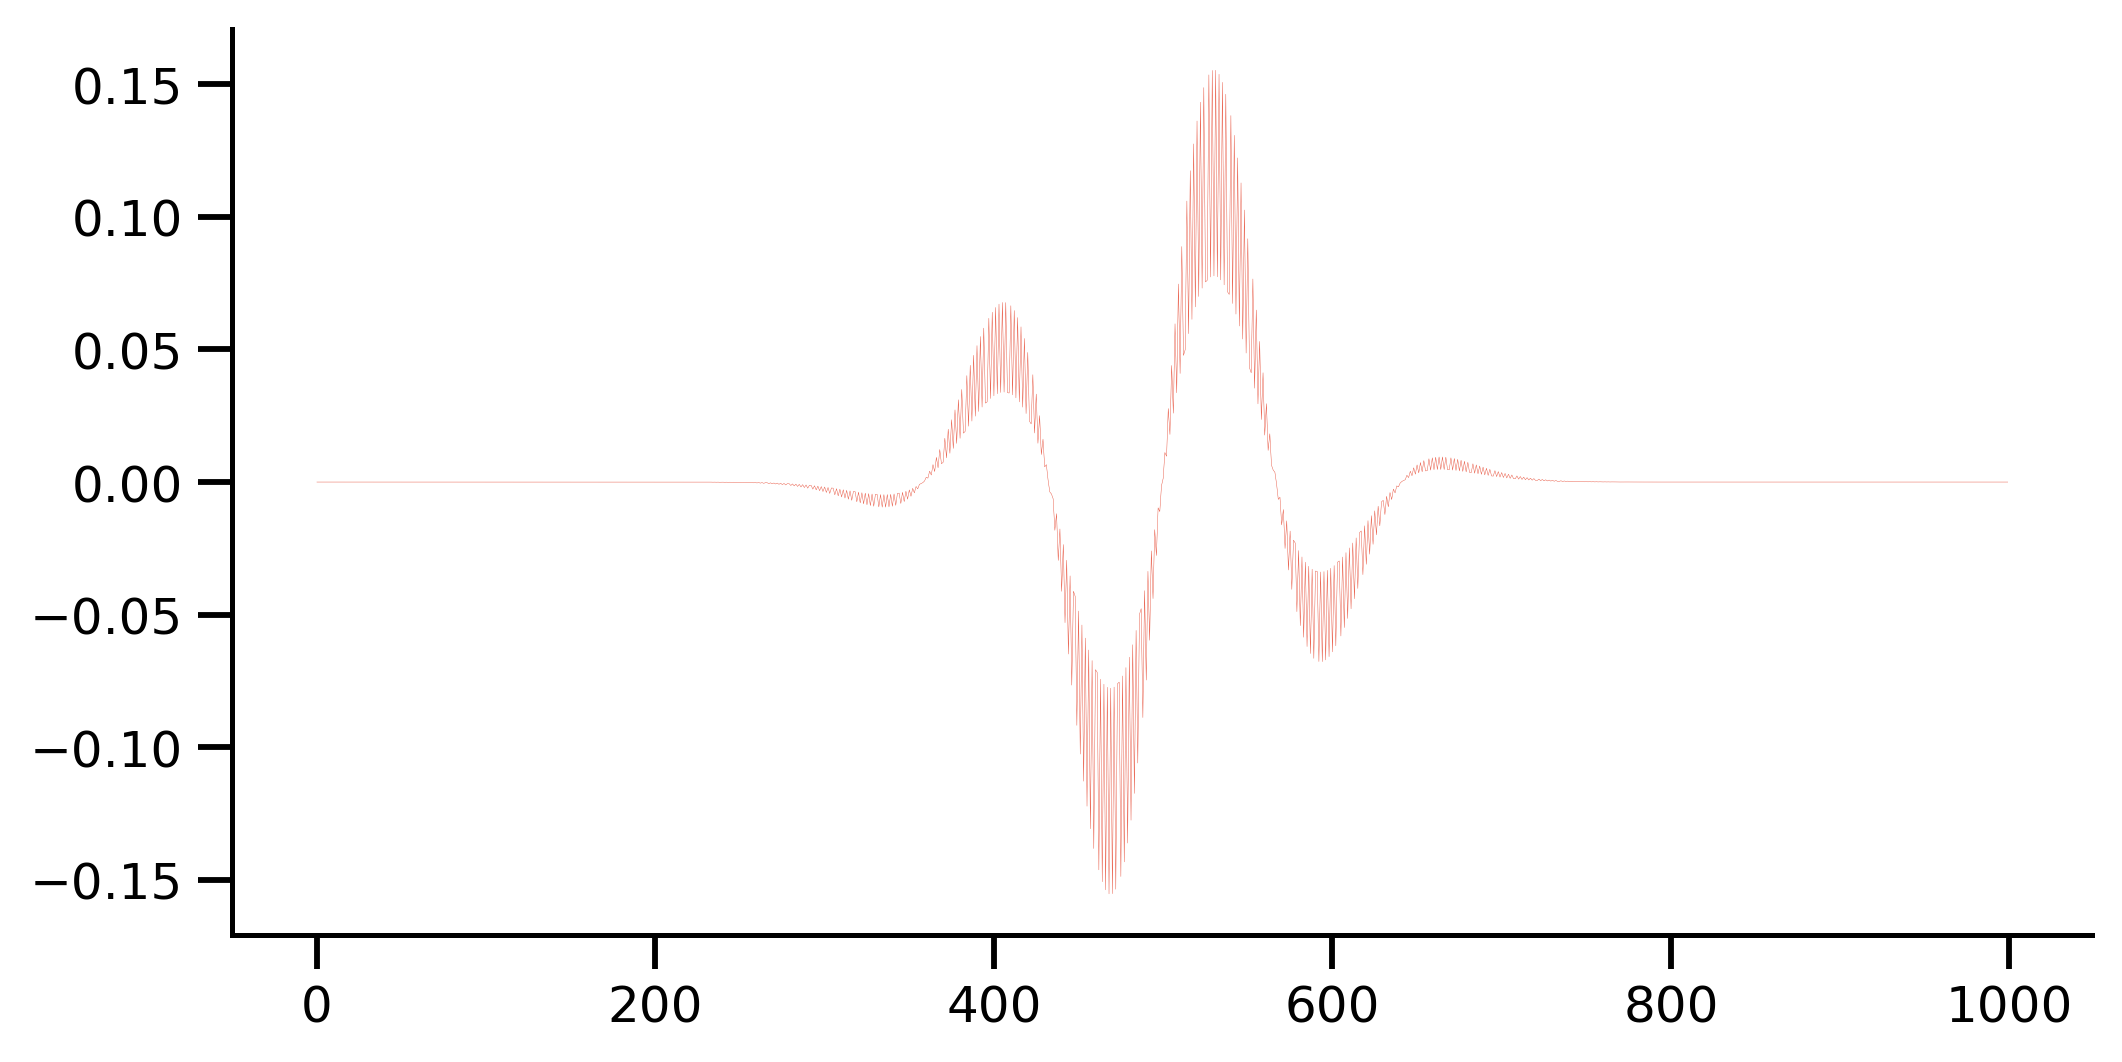

In [237]:
with plt.style.context(splstyle.get_style('nature-reviews')):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 4)
    ax.plot(np.arange(1000),c[-6, :], linewidth=0.1)

In [238]:
np.shape(c[-6, :])

(1000,)

In [239]:
# try discrete wavelet transform 
# c = pywt.dwt(data=_signal, wavelet=wname)

# Multilevel decomposition using wavedec 
# c =  pywt.wavedec(data=_signal, wavelet=wname)

# Statinary wavelet transform 
# This has the advnatage of not downsapmling the signal
# c =  pywt.swt(data=_signal, wavelet=wname, level=3)

In [240]:
np.shape(c)

(74, 1000)

In [241]:
Ind = np.empty(shape=2)
WidthTable = np.empty(shape=len(Scales))

for i in np.arange(len(Scales)):
    # indicators of positive coefficients
    IndPos = (c[i, :] > 0).astype(int)
    # indicators of derivative
    IndDer = np.diff(IndPos)
    if wname == 'sym2':
        # indices of positive slope zero crossings
        IndZeroCross = np.where(IndDer == 1)[0]
    else:
        # indices of negative slope zero crossings
        IndZeroCross = np.where(IndDer == -1)[0]
    IndMax = (IndZeroCross > 499).astype(int)
    Ind[1] = np.min(IndZeroCross[IndMax]) + 1
    IndMin = (IndZeroCross < 499).astype(int)
    Ind[0] = np.max(IndZeroCross[IndMin])
    WidthTable[i] = np.diff(Ind) * dt



In [253]:
WidthTable = WidthTable + np.arange(1, len(Scales)+1) * Eps

# Loop-up table
Scale = np.empty(shape=2)
Scale = np.round(np.interp(xp=WidthTable, fp=Scales, x=Width))  # linear interpolation



In [258]:
Ind

array([427., 125.])

In [259]:
np.diff(Ind)

array([-302.])

In [257]:
Eps

1e-15

In [248]:
Scales

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75])

## Plotting the wavelet shapes

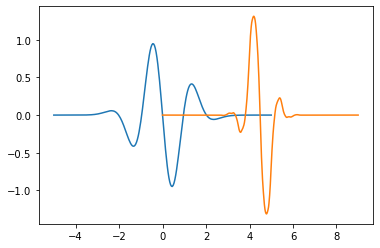

In [142]:
fig, ax = plt.subplots()

wavelet = pywt.ContinuousWavelet('gaus5')
# wavelet_handle = wavelet.wavefun()
wavelet_y, wavelet_x =  wavelet.wavefun()

bior_wavelet = pywt.Wavelet('bior1.5')
bior_output = bior_wavelet.wavefun()
bior_y = bior_output[1]  # quite strange that the first output looks entirely differnt
# why is that, and I can't find this is here either:
# https://uk.mathworks.com/help/wavelet/gs/introduction-to-the-wavelet-families.html
bior_x = bior_output[-1]

ax.plot(wavelet_x, wavelet_y)

ax.plot(bior_x, bior_y)

In [131]:
bior_output[-1]

array([0.00000000e+00, 3.90625000e-03, 7.81250000e-03, ...,
       8.98828125e+00, 8.99218750e+00, 8.99609375e+00])

## Continuous wavelet transform or discrete wavelet transform?

In [120]:
np.shape(bior_output)

(5, 2304)

# Some testing of the wavelets

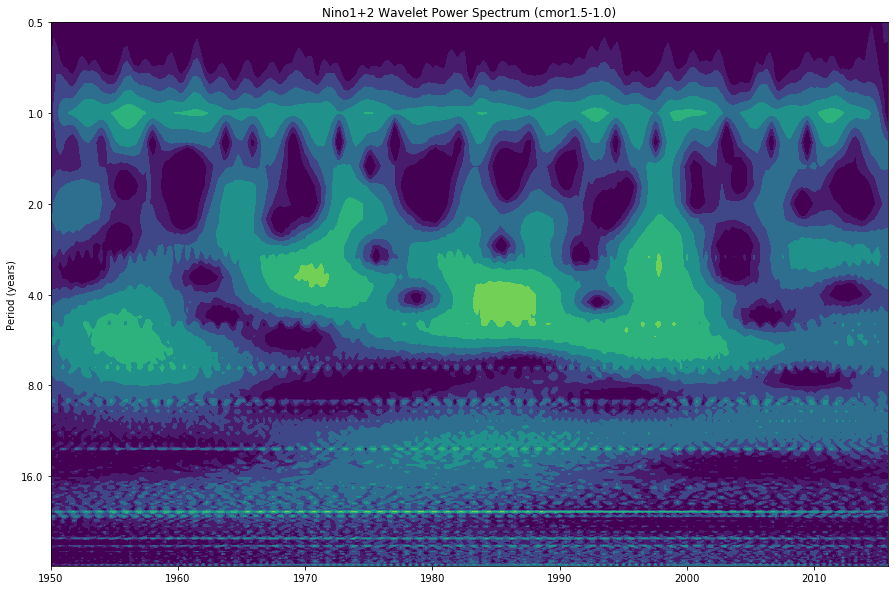

In [53]:
# From: https://github.com/PyWavelets/pywt/blob/580d79d9440ec0f4f936892e39c79ad13a8fd33b/demo/cwt_analysis.py
import numpy as np
import matplotlib.pyplot as plt

import pywt

time, sst = pywt.data.nino()
dt = time[1] - time[0]

# Taken from http://nicolasfauchereau.github.io/climatecode/posts/wavelet-analysis-in-python/
wavelet = 'cmor1.5-1.0'
scales = np.arange(1, 128)

[cfs, frequencies] = pywt.cwt(sst, scales, wavelet, dt)
power = (abs(cfs)) ** 2

period = 1. / frequencies
levels = [0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8]
f, ax = plt.subplots(figsize=(15, 10))
ax.contourf(time, np.log2(period), np.log2(power), np.log2(levels),
            extend='both')

ax.set_title('%s Wavelet Power Spectrum (%s)' % ('Nino1+2', wavelet))
ax.set_ylabel('Period (years)')
Yticks = 2 ** np.arange(np.ceil(np.log2(period.min())),
                        np.ceil(np.log2(period.max())))
ax.set_yticks(np.log2(Yticks))
ax.set_yticklabels(Yticks)
ax.invert_yaxis()
ylim = ax.get_ylim()
ax.set_ylim(ylim[0], -1)

plt.show()